In [7]:
!pip install pandas scikit-learn matplotlib

In [8]:
pip install google-play-scraper

In [9]:
from google_play_scraper import app, Sort, reviews
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from textblob import TextBlob

import csv
import re  # Untuk pencocokan pola teks menggunakan regular expressions
import nltk
import string  # Untuk manipulasi string, seperti menghapus tanda baca
from nltk.corpus import stopwords  # Untuk mengakses kata-kata umum yang biasanya dihapus
from nltk.tokenize import word_tokenize, sent_tokenize  # Untuk tokenisasi kata dan kalimat


MENAMPILKAN DATA

In [10]:
review, continuation_token = reviews(
    'com.netflix.mediaclient',
    lang = 'id',
    country = 'id',
    sort = Sort.NEWEST,
    count = 100
)

In [11]:
app_reviews_df= pd.DataFrame(review)
app_reviews_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,7da13045-6092-4e8a-8869-ad741f08e989,sajito maniki,https://play-lh.googleusercontent.com/a/ACg8oc...,"saya suka karena filmnya banyak yang menarik,d...",5,0,7.120.6 build 63 35594,2024-12-26 05:46:38,None,None,7.120.6 build 63 35594
1,f8f2bbaf-f42d-4693-ad32-6dd25f16698b,Ato Arianto,https://play-lh.googleusercontent.com/a/ACg8oc...,Sangat bagussssssssssss,5,0,None,2024-12-26 05:45:37,None,None,None
2,e41966b5-1ac3-40ac-b8d9-391dca6d8ebc,adrianus ompor,https://play-lh.googleusercontent.com/a-/ALV-U...,Tidak sesuai,1,0,8.141.1 build 13 51230,2024-12-26 05:00:46,None,None,8.141.1 build 13 51230
3,99678500-459a-4b60-a5e3-7e3765b6bd35,Lilis Tyo,https://play-lh.googleusercontent.com/a-/ALV-U...,kok gua daftar ga bisa² ya terus ngulang² mulu...,1,0,None,2024-12-26 04:44:08,None,None,None
4,41791478-6a4d-4635-b093-7cf68d198350,Abah Kamil&Kiya,https://play-lh.googleusercontent.com/a-/ALV-U...,Layarnya sering hitam saat di tonton,1,0,None,2024-12-26 03:58:51,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
95,ed171000-921b-4d98-b7cd-6f45456a8051,Lisnawati Shakayla,https://play-lh.googleusercontent.com/a/ACg8oc...,Akunku jd tiba2 gak bisa dipakai lg knp sih😓,4,0,8.141.1 build 13 51230,2024-12-22 14:17:34,None,None,8.141.1 build 13 51230
96,30797656-cdbd-48bc-89ea-cbd4e803df5e,agus_ darma1946,https://play-lh.googleusercontent.com/a/ACg8oc...,Terbaik,5,0,None,2024-12-22 14:16:14,None,None,None
97,21d4b681-f6aa-4c57-aff9-545b9f38a147,Annida Maharani,https://play-lh.googleusercontent.com/a-/ALV-U...,"Gabisa login harus, bayar dulu baru bisa kebuk...",1,0,None,2024-12-22 12:51:17,None,None,None
98,2eb102ab-280b-4a79-8d43-1bac17684aa0,Cloudds,https://play-lh.googleusercontent.com/a-/ALV-U...,"App bermasalah, mending yg lain",1,0,8.141.1 build 13 51230,2024-12-22 11:13:57,None,None,8.141.1 build 13 51230


PREPROSES DATA

In [12]:
df = pd.read_csv('/com.netflix.mediaclient_reviews_min_100.csv')
df.isnull().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,54
at,0
replyContent,100
repliedAt,100


In [13]:
#label encoding
from sklearn.preprocessing import LabelEncoder

# Function to determine sentiment using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'


# Apply the sentiment analysis to create the 'sentiment' column
df['sentiment'] = df['content'].apply(get_sentiment)

# Now you can proceed with label encoding
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])  # Asumsi kolom sentiment ada di dataframe

In [14]:
#membagi data
X = df['content']  # Asumsi kolom konten adalah 'content'
y = df['sentiment_encoded']

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

EKSTRASI FITUR

In [15]:
# Mengubah teks menjadi fitur numerik dengan Count Vectorizer
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

MODEL TRAINING

In [16]:
# Melatih model Support Vector Machine
model = SVC(probability=True)  # Mengaktifkan probabilitas untuk ROC-AUC
model.fit(X_train_counts, y_train)

SVC(probability=True)

EVALUASI MODEL

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Load your data into a pandas DataFrame (replace 'your_data.csv' with the actual path to your data)
#df = pd.read_csv('/com.netflix.mediaclient_reviews_min_100.csv')

# Assuming you have your data in 'df' with columns 'content' and 'sentiment_encoded'
X = df['content']
y = df['sentiment_encoded']

# 1. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Create a CountVectorizer and fit it ONLY on the training data
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)

# 3. Transform the test data using the SAME fitted vectorizer
X_test_counts = count_vectorizer.transform(X_test)

# 4. Train the MultinomialNB model
model = MultinomialNB()  # Replace SVC with MultinomialNB
model.fit(X_train_counts, y_train)

# 5. Make predictions and evaluate the model
y_pred = model.predict(X_test_counts)

# Menghitung akurasi dan classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Menghitung ROC-AUC (Only for binary classification)
# Check if it's a binary classification problem
if len(model.classes_) == 2:
    y_probs = model.predict_proba(X_test_counts)[:, 1]
    roc_auc = roc_auc_score(y_test, y_probs)

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Accuracy: 85.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       0.85      1.00      0.92        17
           2       1.00      0.00      0.00         2

    accuracy                           0.85        20
   macro avg       0.95      0.33      0.31        20
weighted avg       0.87      0.85      0.78        20

Confusion Matrix:
[[ 0  1  0]
 [ 0 17  0]
 [ 0  2  0]]


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


WordCloud

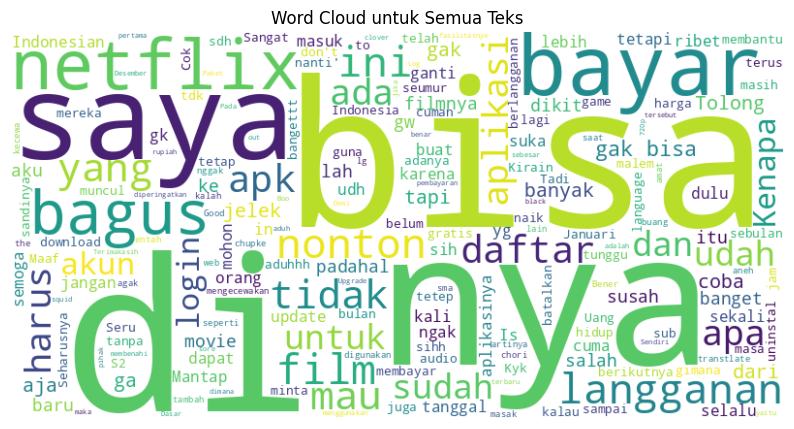

In [19]:
from wordcloud import WordCloud

# Gabungkan semua teks menjadi satu string
all_text = ' '.join(df['content'])

# Membuat word cloud
wordcloud = WordCloud(stopwords='english', background_color='white', width=800, height=400).generate(all_text)

# Menampilkan word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Semua Teks')
plt.show()


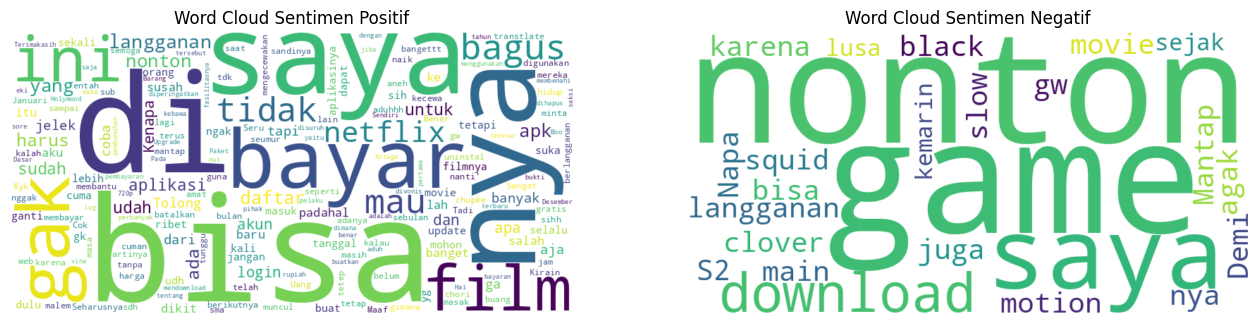

In [20]:
# Filter teks positif dan negatif
positive_text = ' '.join(df[df['sentiment_encoded'] == 1]['content'])
negative_text = ' '.join(df[df['sentiment_encoded'] == 0]['content'])

# Membuat word cloud untuk teks positif dan negatif
positive_wordcloud = WordCloud(stopwords='english', background_color='white', width=800, height=400).generate(positive_text)
negative_wordcloud = WordCloud(stopwords='english', background_color='white', width=800, height=400).generate(negative_text)

# Plotting wordcloud positif dan negatif
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Positif
axs[0].imshow(positive_wordcloud, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Word Cloud Sentimen Positif')

# Negatif
axs[1].imshow(negative_wordcloud, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Word Cloud Sentimen Negatif')

plt.show()

In [21]:
# Memuat dataset
# Ganti 'data.csv' dengan path dataset Anda
df = pd.read_csv('/com.netflix.mediaclient_reviews_min_100.csv')

# --- Add the following lines to create the 'sentiment_encoded' column in df ---
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder

def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['content'].apply(get_sentiment)
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])
# --- End of added lines ---


# Memisahkan ulasan positif dan negatif
positive_reviews = df[df['sentiment_encoded'] == 1]
negative_reviews = df[df['sentiment_encoded'] == 0]

# Menyimpan ke file TSV
positive_reviews.to_csv('positive_reviews.tsv', sep='\t', index=False)
negative_reviews.to_csv('negative_reviews.tsv', sep='\t', index=False)

print("Ulasan positif dan negatif berhasil disimpan ke file TSV!")

Ulasan positif dan negatif berhasil disimpan ke file TSV!


In [22]:
def clean_text(text):
  # mengubah semua karakter huruf menjadi huruf kecil
  text = text.lower()
  # menghilangkan punctuation
  text = re.sub('@[^\s]+', '', text)
  # menghilangkan angka
  text = re.sub('\d+', '', text)
  # menghilangkan URL
  text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
  text = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?\s', '', text)
  # menghilangkan Hastag
  text = re.sub(r'#[^\s]+', '', text)
  # menghilangkan Huruf Tunggal
  text = re.sub(r'\b[a-zA-Z]\b', '', text)
  return text

clean = lambda x: clean_text(x)

dfx = pd.DataFrame(df.content.apply(clean))
dfx

,content
0,saya download+ langganan karena squid game ❤️
1,tidak muncul sub
2,"mau daftar akun aja susah,apa saya yang salah ..."
3,jelek. gak bisa login!!!!
4,pada tanggal desember saya membayar paket da...
...,...
95,kukira gratis teryata bayar
96,tidak bisa digunakan di perangkat lain (tv) cu...
97,ok
98,napa agak slow motion gw nonton nya sejak kema...


ALGORITMA 1 NAIVE BAYES

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Memuat dataset
# df = pd.read_csv('path_to_your_dataset.csv')  # Ganti dengan path dataset Anda
# Misalkan df sudah ada dengan kolom 'text' untuk ulasan dan 'sentiment' untuk label

X = df['content']  # Kolom teks
y = df['sentiment']  # Kolom label sentimen

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mengubah teks menjadi representasi numerik
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Membuat model Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_vect, y_train)

# Memprediksi
y_pred = nb.predict(X_test_vect)

# Evaluasi
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
     neutral       0.95      0.95      0.95        19

    accuracy                           0.90        20
   macro avg       0.47      0.47      0.47        20
weighted avg       0.90      0.90      0.90        20



ALGORITMA 2 SVM (SUPPORT VECTOR MACHINE)

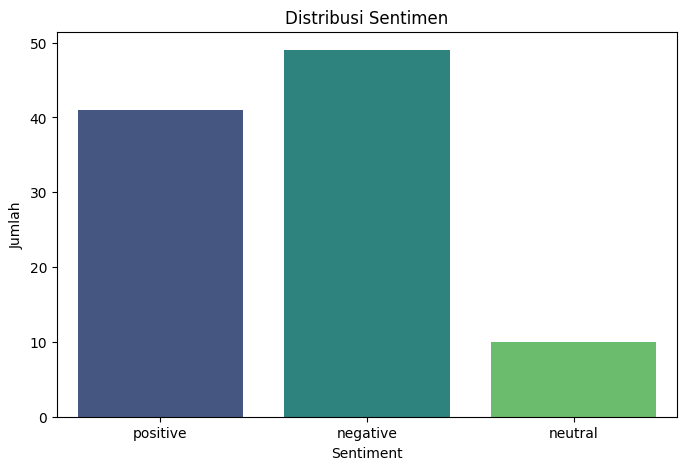

Akurasi: 0.65
              precision    recall  f1-score   support

    negative       0.59      1.00      0.74        10
     neutral       1.00      0.00      0.00         2
    positive       1.00      0.38      0.55         8

    accuracy                           0.65        20
   macro avg       0.86      0.46      0.43        20
weighted avg       0.79      0.65      0.59        20



In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Memuat data
#file_path = '/content/com.netflix.mediaclient_reviews_min_100.csv'  # Ganti dengan path dataset Anda
#df = pd.read_csv(file_path)

# Menentukan sentimen berdasarkan score
# Misalkan kita anggap score >= 4 sebagai 'positive', score == 3 sebagai 'neutral', dan score <= 2 sebagai 'negative'
def determine_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['score'].apply(determine_sentiment)

# Visualisasi distribusi sentimen
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment',  hue='sentiment', palette='viridis', legend=False)
plt.title('Distribusi Sentimen')
plt.xlabel('Sentiment')
plt.ylabel('Jumlah')
plt.show()


# Memisahkan fitur dan target
X = df['content']  # Kolom teks
y = df['sentiment']  # Kolom label sentimen


# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Mengubah teks menjadi representasi numerik menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Membuat model SVM
svm = SVC(kernel='linear', random_state=42)  # Menggunakan kernel linear
svm.fit(X_train_vect, y_train)

# Memprediksi
y_pred = svm.predict(X_test_vect)

# Evaluasi
print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))


SKENARIO 1

Accuracy: 80.00%
Classification Report:
              precision    recall  f1-score   support

       False       0.75      1.00      0.86        24
        True       1.00      0.50      0.67        16

    accuracy                           0.80        40
   macro avg       0.88      0.75      0.76        40
weighted avg       0.85      0.80      0.78        40

Confusion Matrix:
[[24  0]
 [ 8  8]]


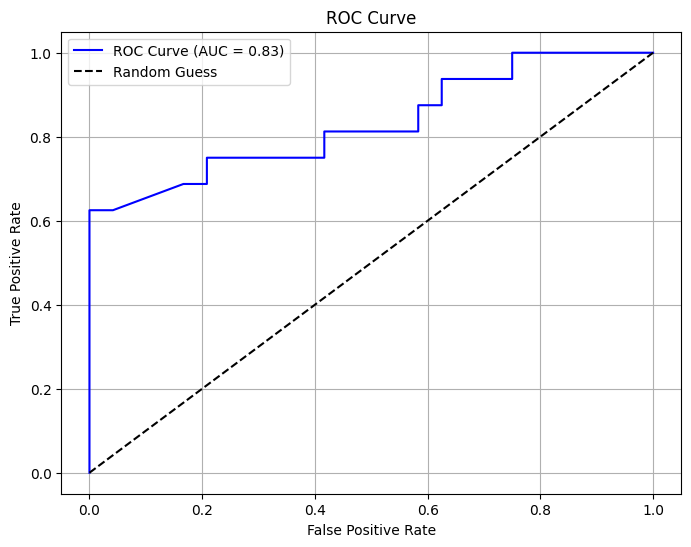

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt



# Menentukan sentimen berdasarkan score
def determine_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['score'].apply(determine_sentiment)

# Memisahkan fitur dan target
X = df['content']  # Kolom teks
y = df['sentiment']  # Kolom label sentimen

# Mengkodekan label sentimen
y_encoded = pd.get_dummies(y).positive  # Menggunakan sentimen positif sebagai target

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.4, random_state=42, stratify=y)

# Mengubah teks menjadi fitur numerik dengan TF-IDF
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Melatih model SVM
model = SVC(kernel='linear', probability=True, random_state=42)  # Menggunakan kernel linear
model.fit(X_train_tfidf, y_train)

# Memprediksi probabilitas untuk ROC-AUC
y_probs = model.predict_proba(X_test_tfidf)[:, 1]

# Menghitung akurasi dan classification report
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Menghitung ROC-AUC
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

SKENARIO 2

Accuracy: 80.00%
Classification Report:
              precision    recall  f1-score   support

       False       0.75      1.00      0.86        24
        True       1.00      0.50      0.67        16

    accuracy                           0.80        40
   macro avg       0.88      0.75      0.76        40
weighted avg       0.85      0.80      0.78        40

Confusion Matrix:
[[24  0]
 [ 8  8]]


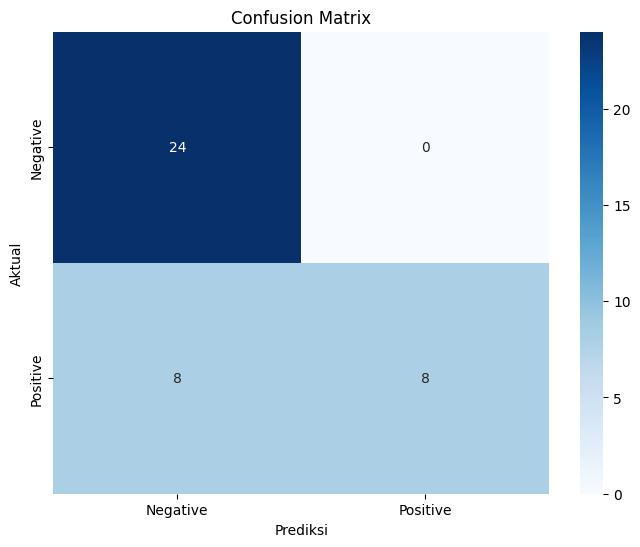

Kesalahan Prediksi:
    Actual  Predicted
32    True      False
17    True      False
37    True      False
1     True      False
52    True      False
12    True      False
85    True      False
69    True      False


In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Menentukan sentimen berdasarkan score
def determine_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['score'].apply(determine_sentiment)

# Memisahkan fitur dan target
X = df['content']  # Kolom teks
y = df['sentiment']  # Kolom label sentimen

# Mengkodekan label sentimen
y_encoded = pd.get_dummies(y, drop_first=True)  # encoding untuk 'positive' dan 'negative'

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded.positive, test_size=0.4, random_state=42, stratify=y)

# Mengubah teks menjadi fitur numerik dengan TF-IDF
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Melatih model SVM
model = SVC(kernel='linear', probability=True, random_state=42)  # Menggunakan kernel linear
model.fit(X_train_tfidf, y_train)

# Memprediksi
y_pred = model.predict(X_test_tfidf)

# Menghitung akurasi dan classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

# Analisis kesalahan
errors = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
errors = errors[errors['Actual'] != errors['Predicted']]
print("Kesalahan Prediksi:")
print(errors.head(10))  # Menampilkan 10 kesalahan prediksi yang pertama

SKENARIO 3

Accuracy: 86.67%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.87      1.00      0.93        26
           2       0.00      0.00      0.00         3

    accuracy                           0.87        30
   macro avg       0.29      0.33      0.31        30
weighted avg       0.75      0.87      0.80        30

Confusion Matrix:
[[ 0  1  0]
 [ 0 26  0]
 [ 0  3  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


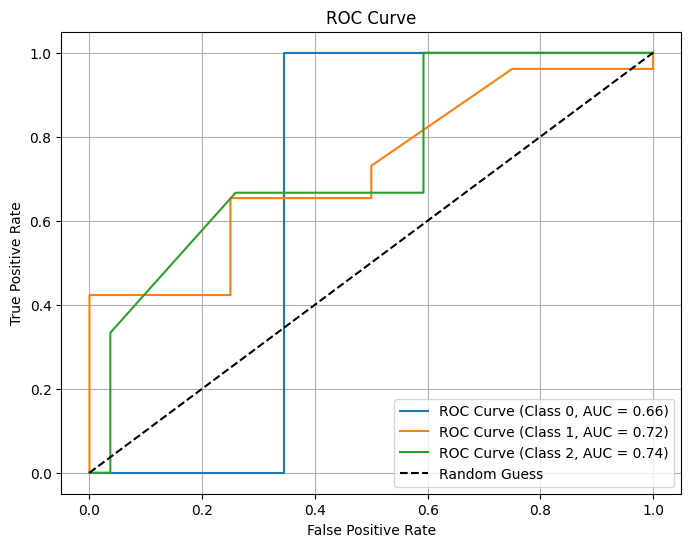

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Memisahkan fitur dan target
X = df['content']  # Kolom teks
y = df['sentiment_encoded']  # Kolom label sentimen yang sudah dienkode

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Mengubah teks menjadi fitur numerik dengan TF-IDF
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Melatih model Multinomial Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Memprediksi probabilitas untuk ROC-AUC
y_probs = model.predict_proba(X_test_tfidf)

# Check if y_probs has the expected shape
if y_probs.ndim == 1:
    y_probs = y_probs[:, np.newaxis]  # Reshape to 2D if necessary


# Menghitung akurasi dan classification report
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Menghitung ROC-AUC
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr')  # or multi_class='ovo'

# Plot ROC Curve
from sklearn.preprocessing import label_binarize


y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Adjust classes if needed
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f'ROC Curve (Class {i}, AUC = {roc_auc_score(y_test_bin[:, i], y_probs[:, i]):.2f})')


plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

SKENARIO 4

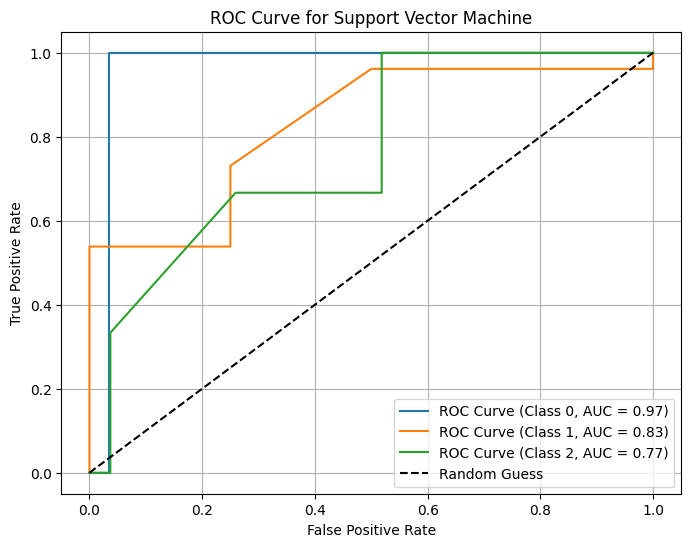

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Memisahkan fitur dan target
X = df['content']  # Kolom teks
y = df['sentiment_encoded']  # Kolom label sentimen yang sudah dienkode

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Mengubah teks menjadi fitur numerik dengan TF-IDF
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Melatih model Support Vector Machine
model = SVC(kernel='linear', probability=True, random_state=42)
model.fit(X_train_tfidf, y_train)

# Memprediksi probabilitas untuk ROC-AUC
y_probs = model.predict_proba(X_test_tfidf)

# Menghitung ROC-AUC
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovo')  # or multi_class='ovo'

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_probs[:, i]) # Calculate AUC for each class
    plt.plot(fpr, tpr, label=f'ROC Curve (Class {i}, AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Support Vector Machine')
plt.legend(loc='best')
plt.grid()
plt.show()

DEPLOYMENT

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import pickle
from textblob import TextBlob # Import TextBlob

# 1. Load Data
data = pd.read_csv('/com.netflix.mediaclient_reviews_min_100.csv')

# 2. Add 'sentiment_encoded' column (like you did in preprocessing)
# Function to determine sentiment using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

data['sentiment'] = data['content'].apply(get_sentiment) # Create sentiment column

from sklearn.preprocessing import LabelEncoder #Import LabelEncoder
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['sentiment'])  # Create sentiment_encoded column


# 3. Preprocessing Pipeline
# Case folding (sudah dilakukan pada data, jadi dilewatkan di sini)
# Vectorization menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['content'])

y = data['sentiment_encoded']  # Target: 0 (Negative), 1 (Positive)

# 4. Split Data untuk Training dan Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Train Model (Naive Bayes)
model = MultinomialNB()
model.fit(X_train, y_train)

# 6. Evaluasi Model
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions, target_names=['negative', 'positive', 'neutral'])

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", report)

# 7. Save Model dan Vectorizer
with open('text_classifier.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

print("Model dan vectorizer berhasil disimpan!")

Accuracy: 85.00%
Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
    positive       0.85      1.00      0.92        17
     neutral       0.00      0.00      0.00         2

    accuracy                           0.85        20
   macro avg       0.28      0.33      0.31        20
weighted avg       0.72      0.85      0.78        20

Model dan vectorizer berhasil disimpan!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.5 MB/s eta 0:00:00


In [31]:
%%writefile app.py
import streamlit as st
import pickle

# Load Model dan Vectorizer
with open('text_classifier.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
    vectorizer = pickle.load(vectorizer_file)

# Fungsi Prediksi
def predict_sentiment(text):
    """Memprediksi sentimen dari teks input."""
    transformed_text = vectorizer.transform([text])  # Preprocessing teks
    prediction = model.predict(transformed_text)  # Prediksi
    sentiment = "Positive" if prediction[0] == 1 else "Negative"
    return sentiment

# Aplikasi Streamlit
st.title("Aplikasi Sentimen Netflix")

# Input User
input_text = st.text_area("Masukkan teks ulasan:", "Ketik ulasan di sini...")

# Tombol Prediksi
if st.button("Prediksi"):
    if input_text.strip():
        result = predict_sentiment(input_text)
        st.success(f"Hasil Prediksi: {result}")
    else:
        st.warning("Silakan masukkan teks untuk diprediksi.")


Writing app.py


In [32]:
!pip install pyngrok

In [33]:
!wget -q -O - ipv4.icanhazip.com

34.139.209.250


In [34]:
!streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.139.209.250:8501

⠙Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧your url is: https://funny-nights-sniff.loca.lt
  Stopping...
^C
